In [1]:
%matplotlib inline
from IPython.display import display
import numpy as np
import pandas as pd
import pyarrow

import io
import zipfile
#import modin.pandas as pd

In [2]:
# a glorious function
# add ordered categories to this
def tweak_gss(gss): 
    income_cats = ['No answer', '0', '1000', '3000', '4000', 
                   '5000', '6000', '7000', '8000', '10000',
                   '15000', '20000', '25000', ]
    return (gss
      .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
             'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]',
             'MAJOR1': 'category',
              **{col: 'category' for col in ['SEX', 'RACE', 'BORN', 
                    'INCOME', 'INCOME06', 'HONEST','TICKET']}})
      .assign(INCOME=lambda a_df: a_df.INCOME.cat.reorder_categories(income_cats, ordered=True),
              TICKET=lambda a_df: a_df.TICKET.str.upper(),
              INCOME_INT=gss.INCOME.replace("No answer", np.nan).astype("uint16[pyarrow]"),
             )
    )

In [3]:
%%time
gss = pd.read_csv('GSS.csv', index_col=0, dtype_backend='pyarrow', engine='pyarrow')

CPU times: user 54.5 ms, sys: 17.7 ms, total: 72.2 ms
Wall time: 27.1 ms


# Idiomatic Pandas
## 5 Tips for Better Pandas Code

https://github.com/mattharrison/2023-scipy-pandas

## About Matt  Harrison @\_\_mharrison\_\_

* Author of Effective Pandas, Machine Learning Pocket Reference, and Illustrated Guide to Python 3.
* Advisor at Ponder (creators of Modin)
* Corporate trainer at MetaSnake. Taught Pandas to 1000's of students.

## Practice this on your data with your team!
* Contact me matt@metasnake.com
* Follow on Twitter @\_\_mharrison\_\_

## Outline

* Load Data
* Types
* Chaining
* Mutation
* Apply
* Aggregation

## Imports

In [4]:
pd.__version__

'2.0.2'

In [5]:
pyarrow.__version__

'12.0.0'

## Types
Getting the right types will enable analysis and correctness.


In [8]:
# Will show help
# pd.read_csv?

In [9]:
gss.dtypes

YEAR         int64[pyarrow]
ID           int64[pyarrow]
AGE         double[pyarrow]
HRS1        double[pyarrow]
OCC          int64[pyarrow]
MAJOR1      string[pyarrow]
SEX         string[pyarrow]
RACE        string[pyarrow]
BORN        string[pyarrow]
INCOME      string[pyarrow]
INCOME06    string[pyarrow]
HONEST      string[pyarrow]
TICKET      string[pyarrow]
dtype: object

In [27]:
gss

,YEAR,ID,AGE,HRS1,OCC,MAJOR1,SEX,RACE,BORN,INCOME,INCOME06,HONEST,TICKET
,,,,,,,,,,,,,
0,1972,1,23.0,<NA>,205,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
1,1972,2,70.0,<NA>,441,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
2,1972,3,48.0,<NA>,270,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
3,1972,4,27.0,<NA>,1,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
4,1972,5,61.0,<NA>,385,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64809,2018,2344,37.0,36.0,9999,No answer,Female,White,Yes,No answer,Refused,No answer,No answer
64810,2018,2345,75.0,36.0,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer
64811,2018,2346,67.0,<NA>,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer


In [28]:
len(dir(gss))

443

In [29]:
len(dir(gss.YEAR))

412

In [30]:
len(set(dir(gss.YEAR)) & set(dir(gss)))

360

In [31]:
gss.memory_usage(deep=True)

Index       518512
YEAR        518512
ID          518512
AGE         526616
HRS1        526616
OCC         518512
MAJOR1      863001
SEX         590912
RACE        583326
BORN        504166
INCOME      603690
INCOME06    689894
HONEST      888283
TICKET      760844
dtype: int64

In [32]:
# 36 M (pandas 1)
# 8.6 M (Pandas 2)
gss.memory_usage(deep=True).sum()

8611396

## Ints

In [33]:
gss.select_dtypes(int).describe()

,YEAR,ID,OCC
count,64814.000000,64814.000000,64814.000000
mean,1994.939180,1151.810211,6418.583284
std,13.465368,828.030233,4618.278478
min,1972.000000,1.000000,1.000000
25%,1984.000000,507.000000,613.000000
50%,1996.000000,1029.500000,9999.000000
75%,2006.000000,1570.000000,9999.000000
max,2018.000000,4510.000000,9999.000000


In [34]:
# chaining
(gss
 .select_dtypes(int)
 .describe()
#.round(1)
#.median()
)

,YEAR,ID,OCC
count,64814.000000,64814.000000,64814.000000
mean,1994.939180,1151.810211,6418.583284
std,13.465368,828.030233,4618.278478
min,1972.000000,1.000000,1.000000
25%,1984.000000,507.000000,613.000000
50%,1996.000000,1029.500000,9999.000000
75%,2006.000000,1570.000000,9999.000000
max,2018.000000,4510.000000,9999.000000


In [35]:
# can comb08 be an int8?
# Do completion on int
np.iinfo(np.int8)

iinfo(min=-128, max=127, dtype=int8)

In [36]:
np.iinfo(np.uint8)

iinfo(min=0, max=255, dtype=uint8)

In [37]:
np.iinfo(np.uint16)

iinfo(min=0, max=65535, dtype=uint16)

In [38]:
# chaining
(gss
 .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]' })
 .select_dtypes(['uint16'])
 .describe()
)

,YEAR,ID,OCC
count,64814.000000,64814.000000,64814.000000
mean,1994.939180,1151.810211,6418.583284
std,13.465368,828.030233,4618.278478
min,1972.000000,1.000000,1.000000
25%,1984.000000,507.000000,613.000000
50%,1996.000000,1029.500000,9999.000000
75%,2006.000000,1570.000000,9999.000000
max,2018.000000,4510.000000,9999.000000


In [39]:
# chaining
# use 'integer' so see all int-like columns
(gss
 .astype({#'YEAR': 'uint16[pyarrow]',
          'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]' }) 
 .select_dtypes(['integer'])  # see https://numpy.org/doc/stable/reference/arrays.scalars.html
 .describe()
)

,YEAR,ID,OCC
count,64814.000000,64814.000000,64814.000000
mean,1994.939180,1151.810211,6418.583284
std,13.465368,828.030233,4618.278478
min,1972.000000,1.000000,1.000000
25%,1984.000000,507.000000,613.000000
50%,1996.000000,1029.500000,9999.000000
75%,2006.000000,1570.000000,9999.000000
max,2018.000000,4510.000000,9999.000000


In [40]:
# Inspect memory usage
(gss
 .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]' }) 
 .memory_usage(deep=True)
 .sum()  # was 36M
)

7469050

## Int Exercise
* Try converting *YEAR* to `'int8'`. What do the values look like?
* Try converting *YEAR* to `'int8[pyarrow]'`. What do the values look like?

In [41]:
(gss
 .astype({'YEAR': 'int8'}) 
 .select_dtypes(['integer'])  # see https://numpy.org/doc/stable/reference/arrays.scalars.html
 .describe()
)

,YEAR,ID,OCC
count,64814.000000,64814.000000,64814.000000
mean,-53.060820,1151.810211,6418.583284
std,13.465368,828.030233,4618.278478
min,-76.000000,1.000000,1.000000
25%,-64.000000,507.000000,613.000000
50%,-52.000000,1029.500000,9999.000000
75%,-42.000000,1570.000000,9999.000000
max,-30.000000,4510.000000,9999.000000


In [43]:
# THIS IS SUPPOSED TO ERROR OUT, READ THE MESSAGE
(gss
 .astype({'YEAR': 'int8[pyarrow]'}) 
 .select_dtypes(['integer'])  # see https://numpy.org/doc/stable/reference/arrays.scalars.html
 .describe()
)

ArrowInvalid: Integer value 1972 not in range: -128 to 127: Error while type casting for column 'YEAR'

## Floats

In [44]:
(gss
.select_dtypes('float'))

,AGE,HRS1
,,
0,23.0,<NA>
1,70.0,<NA>
2,48.0,<NA>
3,27.0,<NA>
4,61.0,<NA>
...,...,...
64809,37.0,36.0
64810,75.0,36.0
64811,67.0,<NA>


In [45]:
# surprise! age and hours worked looks int-like
gss.HRS1.describe()

count    37506.000000
mean        41.303711
std         14.171808
min          0.000000
25%         37.000000
50%         40.000000
75%         48.000000
max         89.000000
Name: HRS1, dtype: double[pyarrow]

In [46]:
# opps! missing values
gss.HRS1.value_counts(dropna=False)

HRS1
<NA>    27308
40.0    12866
50.0     2806
60.0     1981
45.0     1858
        ...  
0.0         7
71.0        3
81.0        3
79.0        3
87.0        3
Name: count, Length: 91, dtype: int64[pyarrow]

In [47]:
# Count of people that are over 50
(gss
 .AGE
 .gt(50)
 .sum()
)

24758

In [48]:
# pct of people that are 50
(gss
 .AGE
 .gt(50)
 .mean()
)

0.38333384944105536

In [49]:
# Find the count of the missing data
(gss
 .isna()
 .sum()
)

YEAR            0
ID              0
AGE           228
HRS1        27308
OCC             0
MAJOR1          0
SEX             0
RACE            0
BORN            0
INCOME          0
INCOME06        0
HONEST          0
TICKET          0
dtype: int64

In [50]:
# where are they missing?
(gss
  .query('HRS1.isna() and OCC==441')
)

,YEAR,ID,AGE,HRS1,OCC,MAJOR1,SEX,RACE,BORN,INCOME,INCOME06,HONEST,TICKET
,,,,,,,,,,,,,
1,1972,2,70.0,<NA>,441,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
55,1972,56,35.0,<NA>,441,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
163,1972,164,44.0,<NA>,441,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
170,1972,171,76.0,<NA>,441,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
375,1972,376,45.0,<NA>,441,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23999,1989,644,64.0,<NA>,441,No answer,Male,White,Yes,15000,Refused,No answer,No answer
24985,1990,93,65.0,<NA>,441,No answer,Male,White,Yes,25000,Refused,No answer,No answer
25655,1990,763,40.0,<NA>,441,No answer,Male,White,Yes,No answer,Refused,No answer,No answer


In [51]:
# where are they missing?
(gss
  .query('AGE.isna()')
)

,YEAR,ID,AGE,HRS1,OCC,MAJOR1,SEX,RACE,BORN,INCOME,INCOME06,HONEST,TICKET
,,,,,,,,,,,,,
228,1972,229,<NA>,<NA>,280,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
344,1972,345,<NA>,<NA>,9999,No answer,Female,Black,No answer,No answer,Refused,No answer,No answer
1038,1972,1039,<NA>,<NA>,370,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
1427,1972,1428,<NA>,<NA>,902,No answer,Male,Black,No answer,No answer,Refused,No answer,No answer
1553,1972,1554,<NA>,<NA>,395,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63124,2018,659,<NA>,<NA>,9999,No answer,Female,Black,Yes,25000,Refused,No answer,No answer
63906,2018,1441,<NA>,16.0,9999,No answer,Female,White,Yes,20000,Refused,No answer,No answer
63938,2018,1473,<NA>,40.0,9999,Business administration,Male,Black,Yes,25000,Refused,No answer,No answer


In [52]:
# where are they missing?
# It turns out that ID is not consistent across years
(gss
  .query('ID == 229')
)

,YEAR,ID,AGE,HRS1,OCC,MAJOR1,SEX,RACE,BORN,INCOME,INCOME06,HONEST,TICKET
,,,,,,,,,,,,,
228,1972,229,<NA>,<NA>,280,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
1841,1973,229,47.0,40.0,394,No answer,Female,White,No answer,8000,Refused,Not mentioned,Yes
3345,1974,229,38.0,<NA>,602,No answer,Female,Other,No answer,20000,Refused,No answer,No
4829,1975,229,63.0,40.0,461,No answer,Male,White,No answer,10000,Refused,Most desirable,No answer
6319,1976,229,37.0,40.0,126,No answer,Female,White,No answer,20000,Refused,Most desirable,No
7818,1977,229,65.0,<NA>,503,No answer,Male,White,Yes,5000,Refused,No answer,No
9348,1978,229,44.0,36.0,230,No answer,Female,White,Yes,25000,Refused,Most desirable,No answer
10880,1980,229,23.0,<NA>,910,No answer,Female,White,Yes,10000,Refused,No answer,Yes
12348,1982,229,75.0,<NA>,492,No answer,Male,White,No,6000,Refused,No answer,Yes


In [53]:
# Convert to integers
(gss
  .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
         'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]'})
)

,YEAR,ID,AGE,HRS1,OCC,MAJOR1,SEX,RACE,BORN,INCOME,INCOME06,HONEST,TICKET
,,,,,,,,,,,,,
0,1972,1,23,<NA>,205,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
1,1972,2,70,<NA>,441,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
2,1972,3,48,<NA>,270,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
3,1972,4,27,<NA>,1,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
4,1972,5,61,<NA>,385,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64809,2018,2344,37,36,9999,No answer,Female,White,Yes,No answer,Refused,No answer,No answer
64810,2018,2345,75,36,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer
64811,2018,2346,67,<NA>,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer


In [54]:
(gss
  .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
         'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]'})
 .memory_usage(deep=True)
 .sum()  # was 36M  
)

6561650

## Float Exercise

* What is the mean of the numeric columns?
* How many values are missing in the numeric columns?

In [55]:
(gss
 .select_dtypes(float)
 .describe()
)

,AGE,HRS1
count,64586.000000,37506.000000
mean,46.099356,41.303711
std,17.534703,14.171808
min,18.000000,0.000000
25%,31.000000,37.000000
50%,44.000000,40.000000
75%,59.000000,48.000000
max,89.000000,89.000000


In [56]:
# Cannot get the mean of strings
(gss
 .mean()
)

TypeError: 'ArrowExtensionArray' with dtype string[pyarrow] does not support reduction 'mean' with pyarrow version 12.0.0. 'mean' may be supported by upgrading pyarrow.

In [58]:
(gss
 .mean(numeric_only=True)
)

YEAR    1994.939180
ID      1151.810211
AGE       46.099356
HRS1      41.303711
OCC     6418.583284
dtype: float64

In [59]:
(gss
 .select_dtypes(float)
 .mean()
)

AGE     46.099356
HRS1    41.303711
dtype: float64

In [60]:
(gss
 .select_dtypes(np.number)
 .mean()
)

YEAR    1994.939180
ID      1151.810211
AGE       46.099356
HRS1      41.303711
OCC     6418.583284
dtype: float64

In [61]:
(gss
 .select_dtypes(float)
 
)

,AGE,HRS1
,,
0,23.0,<NA>
1,70.0,<NA>
2,48.0,<NA>
3,27.0,<NA>
4,61.0,<NA>
...,...,...
64809,37.0,36.0
64810,75.0,36.0
64811,67.0,<NA>


In [62]:
(gss
 .select_dtypes("number")
 .isna()
 .sum()
)

YEAR        0
ID          0
AGE       228
HRS1    27308
OCC         0
dtype: int64

## Objects

In [63]:
# pandas 1.x
(gss
 .select_dtypes(object)
)

""
""
0
1
2
3
4
...
64809
64810
64811


In [64]:
# pandas 2
(gss
 .select_dtypes('string') # str doesn't work
)

,MAJOR1,SEX,RACE,BORN,INCOME,INCOME06,HONEST,TICKET
,,,,,,,,
0,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
1,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
2,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
3,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
4,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
...,...,...,...,...,...,...,...,...
64809,No answer,Female,White,Yes,No answer,Refused,No answer,No answer
64810,No answer,Female,White,Yes,25000,Refused,No answer,No answer
64811,No answer,Female,White,Yes,25000,Refused,No answer,No answer


In [65]:
gss.MAJOR1.isna().any()

False

In [66]:
# My goto method - .value_counts
# looks categorical
(gss.MAJOR1.value_counts(dropna=False))

MAJOR1
No answer                   61191
Business administration       542
Education                     340
Engineering                   197
Nursing                       186
                            ...  
Statistics/Biostatistics        4
Dance                           3
Gerontology                     3
Humanities                      3
Allied health                   3
Name: count, Length: 81, dtype: int64[pyarrow]

In [67]:

(gss
  .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
         'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]',
         'MAJOR1': 'category'})
 .memory_usage(deep=True)
 .sum()  # was 36M  
)

5767112

In [68]:
(gss
 .select_dtypes(object)
 .columns
)

Index([], dtype='object')

In [84]:
g2 = tweak_gss(gss)

In [85]:
# wow!
g2.memory_usage(deep=True).sum()  # was 36M 

5871942

In [86]:
g2.dtypes

YEAR          uint16[pyarrow]
ID            uint16[pyarrow]
AGE            uint8[pyarrow]
HRS1           uint8[pyarrow]
OCC           uint16[pyarrow]
MAJOR1               category
SEX                  category
RACE                 category
BORN                 category
INCOME               category
INCOME06             category
HONEST               category
TICKET                 object
INCOME_INT    uint16[pyarrow]
dtype: object

In [87]:
g2.INCOME.cat.categories

Index(['No answer', '0', '1000', '3000', '4000', '5000', '6000', '7000',
       '8000', '10000', '15000', '20000', '25000'],
      dtype='object')

In [88]:
print(sorted(g2.INCOME.unique()))

['0', '1000', '10000', '15000', '20000', '25000', '3000', '4000', '5000', '6000', '7000', '8000', 'No answer']


In [89]:
g2.MAJOR1


0        No answer
1        No answer
2        No answer
3        No answer
4        No answer
           ...    
64809    No answer
64810    No answer
64811    No answer
64812    No answer
64813    No answer
Name: MAJOR1, Length: 64814, dtype: category
Categories (81, string[pyarrow]): [Accounting/bookkeeping, Administrative Science/Public Administration, Advertising, Agriculture/horticulture, ..., Theology, Urban and Regional Planning, Veterinary medicine, Visual Arts/Graphic Design/Design and Drafting]

## String and Category Exercises
* There is a `.cat` attribute on the category columns. What can you do with this attribute? (Use `dir` or tab completion to inspect).
* Categories can be ordered. How do you order *INCOME*?
* There is an `.str` attribute on the string and category columns. What can you do with this attribute? (Use `dir` or tab completion to inspect).
* Uppercase the values in the *TICKET* column.

In [90]:
dir(g2.MAJOR1.cat)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__frozen',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_accessors',
 '_add_delegate_accessors',
 '_constructor',
 '_delegate_method',
 '_delegate_property_get',
 '_delegate_property_set',
 '_dir_additions',
 '_dir_deletions',
 '_freeze',
 '_hidden_attrs',
 '_index',
 '_name',
 '_parent',
 '_reset_cache',
 '_validate',
 'add_categories',
 'as_ordered',
 'as_unordered',
 'categories',
 'codes',
 'ordered',
 'remove_categories',
 'remove_unused_categories',
 'rename_categories',
 'reorder_categories',
 'set_categories']

In [91]:
 g2.MAJOR1.cat.categories

Index(['Accounting/bookkeeping',
       'Administrative Science/Public Administration', 'Advertising',
       'Agriculture/horticulture', 'Allied health', 'Anthropology',
       'Architecture', 'Art', 'Aviation/Aeronatics', 'Biology',
       'Business administration', 'Chemistry',
       'Child/Human/Family Development', 'Comm. disorders',
       'Communications/speech', 'Computer science', 'Counseling',
       'Criminology/Criminal Justice', 'Dance', 'Dentistry', 'Economics',
       'Education', 'Educational administration', 'Electronics', 'Engineering',
       'English', 'Environmental Science/Ecology', 'Ethnic studies', 'Fashion',
       'Finance', 'Fine Arts', 'Food Science/Nutrition/Culinary Arts',
       'Foreign language', 'Forestry', 'General sciences', 'General studies',
       'Geography', 'Geology', 'Gerontology', 'Health', 'History',
       'Home economics', 'Human Services/Human Resources', 'Humanities',
       'Industrial Relations', 'Industry & techn', 'Information Techn

In [92]:
g2.INCOME.cat.categories

Index(['No answer', '0', '1000', '3000', '4000', '5000', '6000', '7000',
       '8000', '10000', '15000', '20000', '25000'],
      dtype='object')

In [93]:
g2.INCOME.cat.categories

Index(['No answer', '0', '1000', '3000', '4000', '5000', '6000', '7000',
       '8000', '10000', '15000', '20000', '25000'],
      dtype='object')

## Make a Function

## Function Exercise
* Rearrange your notebook. Put the imports, code to load raw data, and tweak function at the top of the notebook. Restart the kernel and validate that your code works.

## Fix Column Names

In [ ]:
# a glorious function
def tweak_gss(gss):
    return (gss
      .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
             'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]',
             'MAJOR1': 'category',
              **{col: 'category' for col in ['SEX', 'RACE', 'BORN', 
                    'INCOME', 'INCOME06', 'HONEST','TICKET']}})
     .rename(columns={'YEAR': 'year', 'ID': 'year_id', 'AGE':'age', 
          'HRS1': 'hours_worked', 'OCC': 'occupation', 
          'MAJOR1': 'college_major', 'SEX':'sex', 
          'RACE':'race', 'BORN':'born_in_US',
          'INCOME':'income_1970', 'INCOME06': 'income_2006',
          'HONEST':'honesty_rank',
          'TICKET':'traffic_ticket'})
    )

tweak_gss(gss)

## Chain

Chaining is also called "flow" programming. Rather than making intermediate variables, just leverage the fact that most operations return a new object and work on that.

The chain should read like a recipe of ordered steps.

(BTW, this is actually what we did above.)

<div class='alert alert-warning'>
    Hint: Leverage <tt>.pipe</tt> if you can't find a way to chain 😉🐼💪
</div>
    




In [94]:
# function is at the top

In [ ]:
# compare chain to this mess

# gss2 = gss.copy()
# year = gss.YEAR
# year_int = year.astype('uint16')
# gss2['year'] = year_int
# id = gss.ID
# id_int = id.astype('uint16')
# gss2['year_id'] = id_int
# occ = gss.OCC
# occ_int = occ.astype('uint16')
# gss2['occupation'] = occ_int

# more of this

In [98]:
# easy to debug
#  - assign to var (df3)
#  - comment out
#  - pipe to display


from IPython.display import display

def get_var(df, var_name):
    globals()[var_name] = df
    return df

# Print hack shows steps in case something messes up

def tweak_gss2(gss):
    return (gss
     .pipe(get_var, 'df3')   
     .pipe(lambda df: print(df.shape) or df)                
      .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
             'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]',
             'MAJOR1': 'category',
              **{col: 'category' for col in ['SEX', 'RACE', 'BORN', 
                    'INCOME', 'INCOME06', 'HONEST','TICKET']}})
     .pipe(lambda df: print(df.shape) or df)                            
     .rename(columns={'YEAR': 'year', 'ID': 'year_id', 'AGE':'age', 
          'HRS1': 'hours_worked', 'OCC': 'occupation', 
          'MAJOR1': 'college_major', 'SEX':'sex', 
          'RACE':'race', 'BORN':'born_in_US',
          'INCOME':'income_1970', 'INCOME06': 'income_2006',
          'HONEST':'honesty_rank',
          'TICKET':'traffic_ticket'})
     .pipe(lambda df: print(df.shape) or df)                            
    )

tweak_gss2(gss)

(64814, 13)
(64814, 13)
(64814, 13)


,year,year_id,age,hours_worked,occupation,college_major,sex,race,born_in_US,income_1970,income_2006,honesty_rank,traffic_ticket
,,,,,,,,,,,,,
0,1972,1,23,<NA>,205,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
1,1972,2,70,<NA>,441,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
2,1972,3,48,<NA>,270,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
3,1972,4,27,<NA>,1,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
4,1972,5,61,<NA>,385,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64809,2018,2344,37,36,9999,No answer,Female,White,Yes,No answer,Refused,No answer,No answer
64810,2018,2345,75,36,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer
64811,2018,2346,67,<NA>,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer


In [97]:
# inspect intermediate data frame
df3

,YEAR,ID,AGE,HRS1,OCC,MAJOR1,SEX,RACE,BORN,INCOME,INCOME06,HONEST,TICKET
,,,,,,,,,,,,,
0,1972,1,23.0,<NA>,205,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
1,1972,2,70.0,<NA>,441,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
2,1972,3,48.0,<NA>,270,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
3,1972,4,27.0,<NA>,1,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
4,1972,5,61.0,<NA>,385,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64809,2018,2344,37.0,36.0,9999,No answer,Female,White,Yes,No answer,Refused,No answer,No answer
64810,2018,2345,75.0,36.0,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer
64811,2018,2346,67.0,<NA>,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer


In [106]:
((df3==gss)
 .all()
 .all()
)

True

## Chain Exercise
* Write a function that acccepts a dataframe and an index value. It should print any rows that match the index and return the dataframe that was passed in.
* Use the function with pipe after each step of the chain. Show the rows for index 2 and 64,813.








## Don't Mutate

> "you are missing the point, inplace rarely actually does something inplace, you are thinking that you are saving memory but you are not."
>
> **jreback** - Pandas core dev



https://github.com/pandas-dev/pandas/issues/16529#issuecomment-676518136

* In general, no performance benefits
* Prohibits chaining
* ``SettingWithCopyWarning`` fun


In [111]:
def track_rows(df_, indices):
    display(df_.loc[indicies])
    return df_

In [113]:
def tweak_gss2(gss):
    return (gss
     .pipe(get_var, 'df3')   
     .pipe(track_rows, indices=[1000,6000,60000])                
      .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
             'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]',
             'MAJOR1': 'category',
              **{col: 'category' for col in ['SEX', 'RACE', 'BORN', 
                    'INCOME', 'INCOME06', 'HONEST','TICKET']}})
     .pipe(lambda df: print(df.shape) or df)                            
     .rename(columns={'YEAR': 'year', 'ID': 'year_id', 'AGE':'age', 
          'HRS1': 'hours_worked', 'OCC': 'occupation', 
          'MAJOR1': 'college_major', 'SEX':'sex', 
          'RACE':'race', 'BORN':'born_in_US',
          'INCOME':'income_1970', 'INCOME06': 'income_2006',
          'HONEST':'honesty_rank',
          'TICKET':'traffic_ticket'})
     .pipe(lambda df: print(df.shape) or df)                            
    )

tweak_gss2(gss)

NameError: name 'indicies' is not defined

## Don't Apply (if you can)

In [114]:
# a glorious function
def tweak_gss(gss):
    return (gss
      .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
             'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]',
             'MAJOR1': 'category',
              **{col: 'category' for col in ['SEX', 'RACE', 'BORN', 
                    'INCOME', 'INCOME06', 'HONEST','TICKET']}})
     .rename(columns={'YEAR': 'year', 'ID': 'year_id', 'AGE':'age', 
          'HRS1': 'hours_worked', 'OCC': 'occupation', 
          'MAJOR1': 'college_major', 'SEX':'sex', 
          'RACE':'race', 'BORN':'born_in_US',
          'INCOME':'income_1970', 'INCOME06': 'income_2006',
          'HONEST':'honesty_rank',
          'TICKET':'traffic_ticket'})
    )

gss2 = tweak_gss(gss)

In [115]:
# convert age to months
def to_months(val):
    return val * 12

gss2.age.apply(to_months)


0        276
1        840
2        576
3        324
4        732
        ... 
64809    444
64810    900
64811    804
64812    864
64813    948
Name: age, Length: 64814, dtype: object

In [116]:
# this gives the sames results
gss2.age * 12


0        276
1        840
2        576
3        324
4        732
        ... 
64809    444
64810    900
64811    804
64812    864
64813    948
Name: age, Length: 64814, dtype: int64[pyarrow]

In [117]:
%%timeit
gss2.age.apply(to_months)

7.12 ms ± 355 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [118]:
%%timeit
gss2.age * 12

182 µs ± 3.73 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [119]:
# ~42x slower!
7_120 / 182

39.120879120879124

In [120]:
gss.MAJOR1.value_counts()[:20]

MAJOR1
No answer                                    61191
Business administration                        542
Education                                      340
Engineering                                    197
Nursing                                        186
Health                                         127
Psychology                                     127
Accounting/bookkeeping                         119
English                                        100
Computer science                                99
Biology                                         97
Communications/speech                           82
Political science/international relations       71
Law                                             68
Other                                           66
History                                         62
Economics                                       62
Criminology/Criminal Justice                    60
Medicine                                        57
Social work             

In [121]:
def is_science(val):
    return val in {'Engineering', 'Computer science', 'Biology'}

In [122]:
%%timeit
# string
gss.MAJOR1.apply(is_science)

12.6 ms ± 611 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [123]:
%%timeit
gss.MAJOR1.isin({'Engineering', 'Computer science', 'Biology'})

691 µs ± 52.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [124]:
%%timeit
# categorical
gss2.college_major.isin({'Engineering', 'Computer science', 'Biology'})

988 µs ± 32.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Apply Exercise
* Make a new column called *minutes_worked* derived the *hours_worked* column.
* Make a new column called *income_ratio*.
  * Convert the income columns to numbers (replace `'No answer'` and `'Refused'` with `np.nan`).
  * Fill in the missing values with the median
  * Divide the 2006 value by 1970 value

## Master Aggregation

Let's compare age by sex by year...🤔

In [141]:
gss2

,year,year_id,age,hours_worked,occupation,college_major,sex,race,born_in_US,income_1970,income_2006,honesty_rank,traffic_ticket
,,,,,,,,,,,,,
0,1972,1,23,<NA>,205,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
1,1972,2,70,<NA>,441,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
2,1972,3,48,<NA>,270,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
3,1972,4,27,<NA>,1,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
4,1972,5,61,<NA>,385,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64809,2018,2344,37,36,9999,No answer,Female,White,Yes,No answer,Refused,No answer,No answer
64810,2018,2345,75,36,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer
64811,2018,2346,67,<NA>,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer


In [142]:
(gss2
   .groupby('year')
   .mean()
)
# ERRORS b/c of categories!

TypeError: 'Categorical' with dtype category does not support reduction 'mean'

In [143]:
(gss2
   .groupby('year')
   .mean(numeric_only=True)
)

,year_id,age,hours_worked,occupation
year,,,,
1972,807.000000,44.950871,<NA>,1444.870428
1973,752.500000,44.182000,39,1424.382314
1974,742.500000,44.591340,39,1296.756065
1975,879.778523,44.307744,38,1342.724161
1976,878.939293,45.286671,39,1403.899266
1977,765.500000,44.663165,40,1184.355556
1978,766.500000,44.009836,40,1261.514360
1980,734.500000,44.974640,41,1237.329019
1982,1143.105914,44.859079,39,1136.556452


In [144]:
# Indexing operation with a list passed in
(gss2
   .groupby('year')
   [['age', 'hours_worked']]
   .mean()
)

,age,hours_worked
year,,
1972,44.950871,<NA>
1973,44.182000,39
1974,44.591340,39
1975,44.307744,38
1976,45.286671,39
1977,44.663165,40
1978,44.009836,40
1980,44.974640,41
1982,44.859079,39


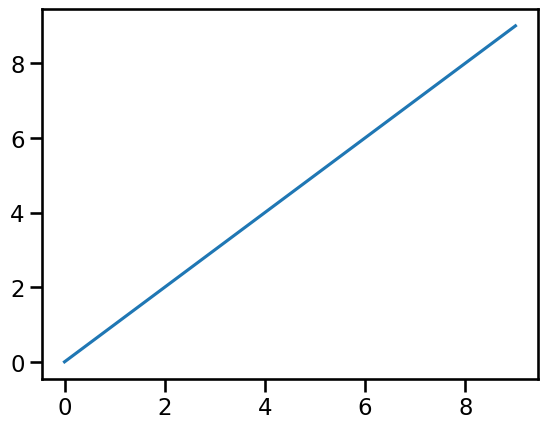

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('pandas1book') 
sns.set_context('talk')
plt.plot(range(10))

<Axes: xlabel='year'>

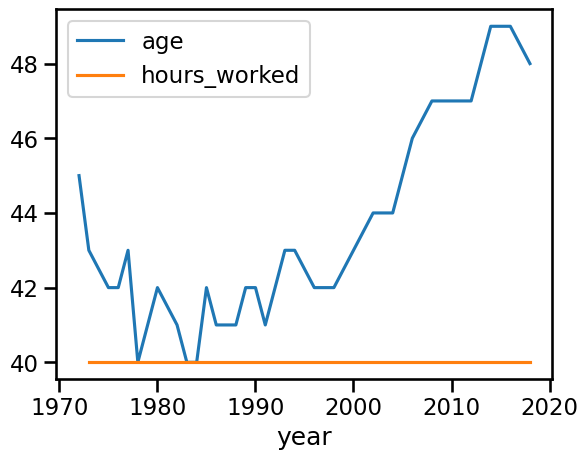

In [146]:
(gss2
   .groupby('year')
   [['age', 'hours_worked']]
   .median()
   .plot()
)

<Axes: xlabel='year'>

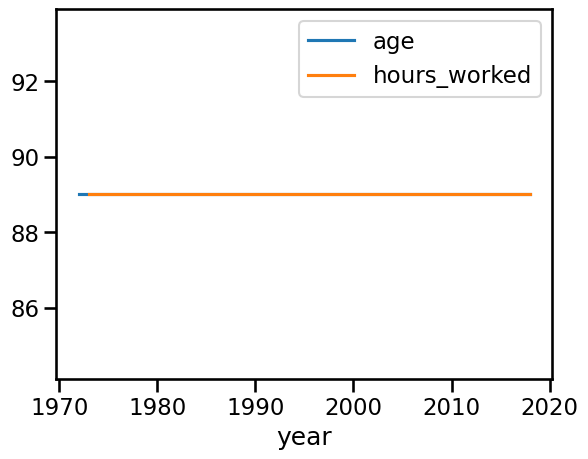

In [147]:
(gss2
   .groupby('year')
   [['age', 'hours_worked']]
   #.mean()
   #.median()
   #.std()
   .max()
   .plot()
)

In [148]:
# add sex
(gss2
   .groupby(['year', 'sex'])
   [['age', 'hours_worked']]
   .mean()
   #.median()
   #.std()
   #.max()
   #.plot()
)

age  hours_worked
year sex                            
1972 Female  45.987547          <NA>
     Male    43.916770          <NA>
1973 Female  43.974969            32
     Male    44.417974            44
1974 Female  43.676806            35
...                ...           ...
2014 Male    48.779438            44
2016 Female  49.818927            37
     Male    48.329403            44
2018 Female  48.740712            38
     Male    49.255481            44

[64 rows x 2 columns]

<Axes: xlabel='year,sex'>

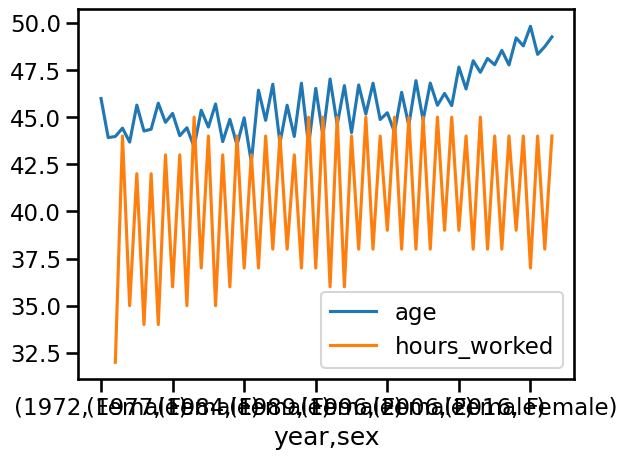

In [149]:
# add sex
(gss2
   .groupby(['year', 'sex'])
   [['age', 'hours_worked']]
   .mean()
   #.median()
   #.std()
   #.max()
   .plot()
)

<Axes: xlabel='year'>

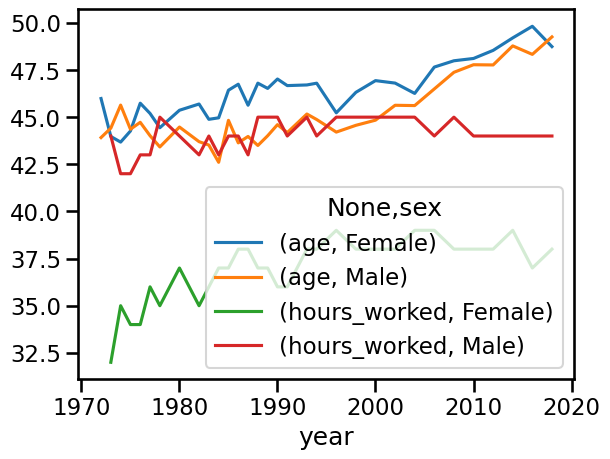

In [155]:
# unstack
(gss2
   .groupby(['year', 'sex'])
   [['age', 'hours_worked']]
   .mean()
   #.median()
   #.std()
   #.max()
   .unstack() 
   .plot()

)

In [156]:
(gss2
   .groupby(['year', 'sex'])
   [['age', 'hours_worked']]
   .mean()
   .unstack()
   .age
)

sex,Female,Male
year,,
1972,45.987547,43.916770
1973,43.974969,44.417974
1974,43.676806,45.638607
1975,44.265031,44.359701
1976,45.739709,44.725637
1977,45.196407,44.015988
1978,44.438279,43.420561
1980,45.365526,44.475819
1982,45.696545,43.700258


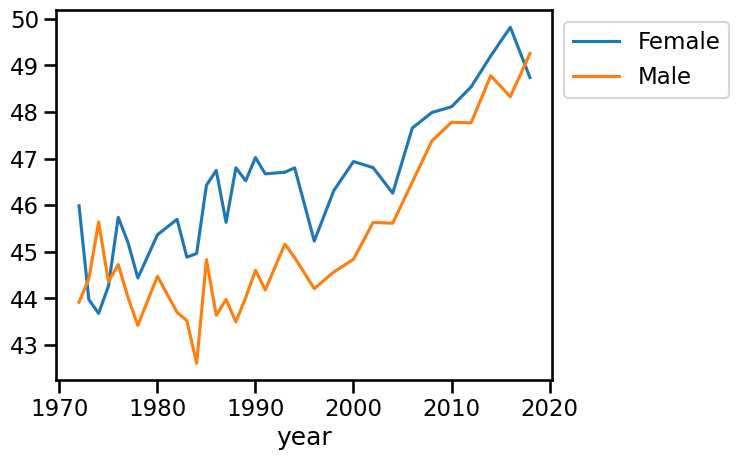

In [157]:
(gss2
   .groupby(['year', 'sex'])
   [['age', 'hours_worked']]
   .mean()
   .unstack()
   .age
   .plot()
   .legend(bbox_to_anchor=(1,1))
)

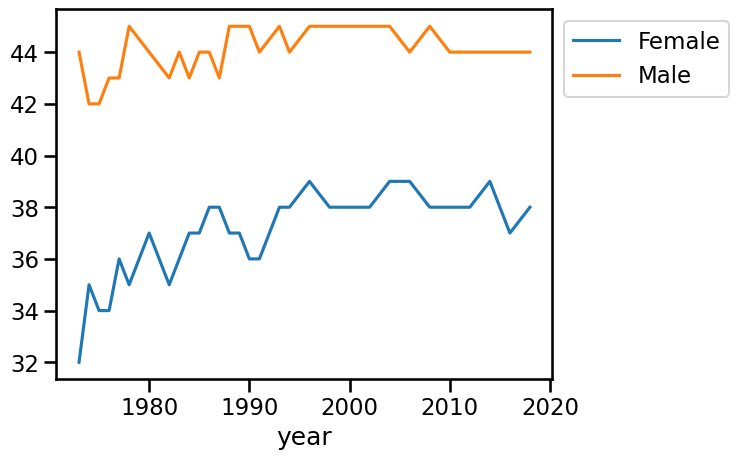

In [158]:
# Let's try looking at hours worked
(gss2
   .groupby(['year', 'sex'])
   [['age', 'hours_worked']]
   .mean()
   .unstack()
   .hours_worked
   .plot()
   .legend(bbox_to_anchor=(1,1))
)

In [159]:
# Multiple aggregates
def second(group):
    return group.iloc[1]
(gss2
   .groupby(['year', 'sex'])
   [['age', 'hours_worked']]
  .agg(['min', 'max', 'mean', second])
   
)

age                       hours_worked                   
            min max       mean second          min   max  mean second
year sex                                                             
1972 Female  18  89  45.987547     48         <NA>  <NA>  <NA>   <NA>
     Male    18  89  43.916770     26         <NA>  <NA>  <NA>   <NA>
1973 Female  18  86  43.974969     36            1    80    32     40
     Male    18  89  44.417974     32            0    89    44     40
1974 Female  18  89  43.676806     69            8    89    35   <NA>
...          ..  ..        ...    ...          ...   ...   ...    ...
2014 Male    18  89  48.779438     59            1    89    44   <NA>
2016 Female  18  89  49.818927     55            1    89    37      5
     Male    18  89  48.329403     61            1    89    44     42
2018 Female  18  89  48.740712     63            1    89    38     40
     Male    18  89  49.255481     42            1    89    44     40

[64 rows x 8 columns]

## Aggregation Exercise
* Which occupation has the highest median hours worked?
* Which occupation has the lowest age?
* What is the breakdown of respondents by race for each year?
* Convert the previous to a percentage.
* How many unique occupations are there for each year?
* What is the most popular college_major for each year?
* What is the second most popular college_major for each year?

In [132]:
gss

,YEAR,ID,AGE,HRS1,OCC,MAJOR1,SEX,RACE,BORN,INCOME,INCOME06,HONEST,TICKET
,,,,,,,,,,,,,
0,1972,1,23.0,<NA>,205,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
1,1972,2,70.0,<NA>,441,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
2,1972,3,48.0,<NA>,270,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
3,1972,4,27.0,<NA>,1,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
4,1972,5,61.0,<NA>,385,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64809,2018,2344,37.0,36.0,9999,No answer,Female,White,Yes,No answer,Refused,No answer,No answer
64810,2018,2345,75.0,36.0,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer
64811,2018,2346,67.0,<NA>,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer


In [160]:
income_cats = ['No answer', '0', '1000', '3000', '4000', 
               '5000', '6000', '7000', '8000', '10000',
               '15000', '20000', '25000', ]

def calc_income_ratio(df_):
    inc_70 = df_.INCOME.replace("No answer", np.nan).astype("int64[pyarrow]")
    inc_06 = df_.INCOME06.replace("No answer", np.nan).replace("Refused", np.nan).astype("int64[pyarrow]")
    return (inc_06.fillna(inc_06.median()) / inc_70.fillna(inc_70.median()))

(gss
      .astype({'YEAR': 'uint16[pyarrow]', 'ID': 'uint16[pyarrow]', 'OCC': 'uint16[pyarrow]',
             'HRS1': 'uint8[pyarrow]', 'AGE': 'uint8[pyarrow]',
             'MAJOR1': 'category',
              **{col: 'category' for col in ['SEX', 'RACE', 'BORN', 
                    'INCOME', 'INCOME06', 'HONEST','TICKET']}})
      .assign(INCOME=lambda a_df: a_df.INCOME.cat.reorder_categories(income_cats, ordered=True),
              TICKET=lambda a_df: a_df.TICKET.str.upper(),
              INCOME_INT=gss.INCOME.replace("No answer", np.nan).astype("uint16[pyarrow]"),
              minutes_worked=lambda df_:df_.HRS1 * 60,
              income_ratio=calc_income_ratio,
             )
    )

,YEAR,ID,AGE,HRS1,OCC,MAJOR1,SEX,RACE,BORN,INCOME,INCOME06,HONEST,TICKET,INCOME_INT,minutes_worked,income_ratio
,,,,,,,,,,,,,,,,
0,1972,1,23,<NA>,205,No answer,Female,White,No answer,No answer,Refused,No answer,NO ANSWER,<NA>,<NA>,1.6
1,1972,2,70,<NA>,441,No answer,Male,White,No answer,No answer,Refused,No answer,NO ANSWER,<NA>,<NA>,1.6
2,1972,3,48,<NA>,270,No answer,Female,White,No answer,No answer,Refused,No answer,NO ANSWER,<NA>,<NA>,1.6
3,1972,4,27,<NA>,1,No answer,Female,White,No answer,No answer,Refused,No answer,NO ANSWER,<NA>,<NA>,1.6
4,1972,5,61,<NA>,385,No answer,Female,White,No answer,No answer,Refused,No answer,NO ANSWER,<NA>,<NA>,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64809,2018,2344,37,36,9999,No answer,Female,White,Yes,No answer,Refused,No answer,NO ANSWER,<NA>,2160,1.6
64810,2018,2345,75,36,9999,No answer,Female,White,Yes,25000,Refused,No answer,NO ANSWER,25000,2160,1.6
64811,2018,2346,67,<NA>,9999,No answer,Female,White,Yes,25000,Refused,No answer,NO ANSWER,25000,<NA>,1.6


In [171]:
gss2

,year,year_id,age,hours_worked,occupation,college_major,sex,race,born_in_US,income_1970,income_2006,honesty_rank,traffic_ticket
,,,,,,,,,,,,,
0,1972,1,23,<NA>,205,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
1,1972,2,70,<NA>,441,No answer,Male,White,No answer,No answer,Refused,No answer,No answer
2,1972,3,48,<NA>,270,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
3,1972,4,27,<NA>,1,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
4,1972,5,61,<NA>,385,No answer,Female,White,No answer,No answer,Refused,No answer,No answer
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64809,2018,2344,37,36,9999,No answer,Female,White,Yes,No answer,Refused,No answer,No answer
64810,2018,2345,75,36,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer
64811,2018,2346,67,<NA>,9999,No answer,Female,White,Yes,25000,Refused,No answer,No answer


In [177]:
(gss2
.groupby(["occupation"])
 [["hours_worked"]]
 .agg("median")
)

,hours_worked
occupation,
1,40
2,46
3,40
4,40
5,40
...,...
982,40
983,19
984,18


In [189]:
(gss
 .query("MAJOR1 != No Answer")
 .groupby(["YEAR", "MAJOR1"])
 .size()
 .unstack()
 .T
 .idxmax()
)

SyntaxError: invalid syntax (<unknown>, line 1)

In [ ]:
(gss
 .groupby("YEAR")
 .MAJOR1
 .value_counts()
 .unstack()
 .plot()
 .legend(bbox_to_anchor())
)

NameError: name 'bbox_to_anchor' is not defined

## Summary

* Correct types save space and enable convenient math, string, and date functionality
* Chaining operations will:
   * Make code readable
   * Remove bugs
   * Easier to debug
* Don't mutate (there's no point). Embrace chaining.
* ``.apply`` is slow for math
* Aggregations are powerful. Play with them until they make sense

Follow on Twitter ``@__mharrison__``

Book giveaway!

In [ ]:
import random
random.randrange(1,13)